# **Finetuning Qwen2-VL following the guide from: https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook**

# Download dataset and Install libraries

In [ ]:
!git clone https://github.com/mtue04/CapyData_ImageCaptioning.git

In [ ]:
!gdown --id 170TGmX-dx521qe436Ha_MIESztixyTes -O data.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=170TGmX-dx521qe436Ha_MIESztixyTes
From (redirected): https://drive.google.com/uc?id=170TGmX-dx521qe436Ha_MIESztixyTes&confirm=t&uuid=21187dc4-46cd-43f2-866a-1e26fee90e18
To: /content/data.zip
100% 444M/444M [00:04<00:00, 109MB/s]


In [ ]:
!unzip -q data.zip -d ./data

In [ ]:
!pip install -qq datasets unsloth==2025.3.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 25.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

# Import libraries

In [ ]:
# --- Standard library ---
import os

# --- Data processing ---
import pandas as pd

# --- Deep learning frameworks ---
import torch

# --- Hugging Face Transformers ---
from transformers import AutoTokenizer, TextStreamer

# --- 🤗 Datasets (avoid PIL.Image) ---
from datasets import Dataset, Features, Value, Image as dImage

# --- PIL ---
from PIL import Image as Image

# --- TRL for SFT training ---
from trl import SFTTrainer, SFTConfig

# --- Unsloth vision model & utilities ---
from unsloth import FastVisionModel, is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator

# --- Regex ---
import re

# Create dataset for Finetuning

In [ ]:
# 1. Read captions.txt
df = pd.read_csv(
    "data/data/train/captions.txt",
    sep="\t",
    names=["image", "text"],
    dtype=str
)
# 2. Convert to right file path
df["image"] = df["image"].apply(lambda fn: os.path.join("data/data/train/images", fn))

# 3. Create right structure
features = Features({
    "image": dImage(),
    "text": Value("string")
})

# 4. Create Dataset
train_dataset = Dataset.from_pandas(df, features=features, preserve_index=False)
print(train_dataset)

Dataset({
    features: ['image', 'text'],
    num_rows: 6275
})


# Load model with Unsloth

In [ ]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

# Demo running model with a sample

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = train_dataset[3]['image']
instruction = " <MAXLEN20> Bạn hoạt động như một bình luận viên thể thao. Hãy mô tả ảnh này (dưới 20 từ) với các đặc điểm như hành động, bối cảnh, cảm xúc, vận động viên"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
train_dataset[3]['image']
response = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 36,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Một vận động viên đang tập bắn cung, với ánh sáng mạnh mẽ từ phía sau, tạo nên một cảm giác tập trung và quyết tâm.<|im_end|>


In [ ]:
display(train_dataset[3]['image'])
print(f"Ground truth: {train_dataset[3]['text']}")
print(f"Generated: {tokenizer.decode(response[0])}")

# Training Config:
- Prompt
- Set up dataset
- Create training pipeline

In [ ]:
instruction = " <MAXLEN20> Bạn hoạt động như một bình luận viên thể thao. Hãy mô tả ảnh này (dưới 20 từ) với các đặc điểm như hành động, bối cảnh, cảm xúc, vận động viên."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }


In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in train_dataset]

In [ ]:
converted_dataset[100]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': ' <MAXLEN20> Bạn hoạt động như một bình luận viên thể thao. Hãy mô tả ảnh này (dưới 20 từ) với các đặc điểm như hành động, bối cảnh, cảm xúc, vận động viên.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=382x448>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'người vận_động_viên giữ thăng_bằng trên tay_chân đưa lên tạo_dáng độc_đáo khi bắn cung'}]}]}

In [ ]:
FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 200,
        #num_train_epochs = 3, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 1024,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
#Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
7.82 GB of memory reserved.


# Start finetuning

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 6,275 | Num Epochs = 1 | Total steps = 200
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 50,855,936/7,000,000,000 (0.73% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,3.771800
2,3.753800
3,3.709300
4,3.613000
5,3.433500
6,3.021000
7,2.603300
8,2.129200
9,1.968700
10,1.755000


# Test inferencing model for 1 sample

In [ ]:
# 1. Đọc file captions.txt (format: image.jpg \t caption)
df = pd.read_csv(
    "data/data/test/captions.txt",
    sep="\t",
    names=["image", "text"],
    dtype=str
)
# 2. Chuyển path ảnh thành đường dẫn đầy đủ
df["image"] = df["image"].apply(lambda fn: os.path.join("data/data/test/images", fn))

# # 3. Định nghĩa features để cast đúng kiểu
features = Features({
    "image": dImage(),
    "text": Value("string")
})

# 4. Tạo Dataset và cast
test_dataset = Dataset.from_pandas(df, features=features, preserve_index=False)
print(test_dataset)

Dataset({
    features: ['image', 'text'],
    num_rows: 1395
})


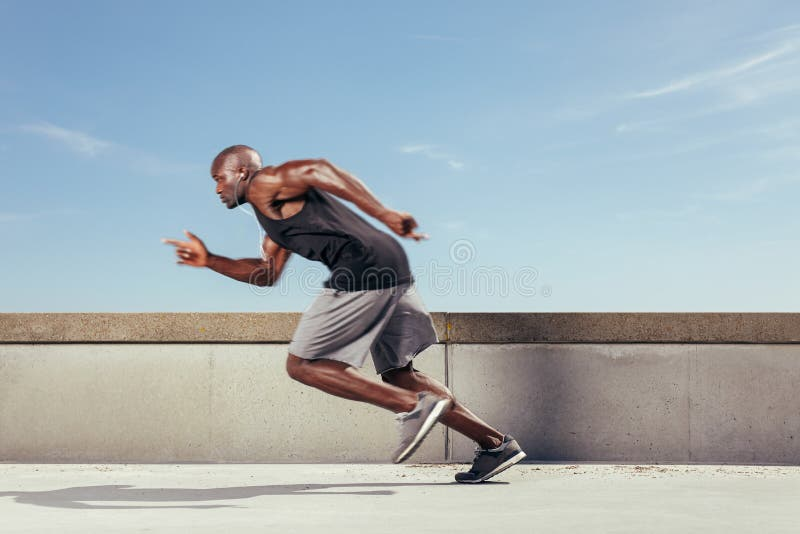

vận_động_viên đang chạy nhanh trên nền trời xanh tạo nên không_khí sôi_động<|im_end|>


In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = test_dataset[100]['image']
instruction =  " <MAXLEN20> Bạn hoạt động như một bình luận viên thể thao. Hãy mô tả ảnh này (dưới 20 từ) với các đặc điểm như hành động, bối cảnh, cảm xúc, vận động viên."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
display(image)
response = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 36,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

# Save model to huggingface

In [ ]:
# Sau khi train xong
trainer.save_model("my-qwen2-vl-finetuned")
tokenizer.save_pretrained("my-qwen2-vl-finetuned")


[]

In [ ]:
from huggingface_hub import HfApi

repo_id = "loc1105/qwen2-capydata-captioning"
api = HfApi()
api.create_repo(repo_id, exist_ok=True)

# upload toàn bộ thư mục
api.upload_folder(
    folder_path="my-qwen2-vl-finetuned",
    repo_id=repo_id,
    repo_type="model",
)


training_args.bin:   0%|          | 0.00/5.62k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/204M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/loc1105/qwen2-capydata-captioning/commit/b09465d0f12387eea719173d57b0b89903c94950', commit_message='Upload folder using huggingface_hub', commit_description='', oid='b09465d0f12387eea719173d57b0b89903c94950', pr_url=None, repo_url=RepoUrl('https://huggingface.co/loc1105/qwen2-capydata-captioning', endpoint='https://huggingface.co', repo_type='model', repo_id='loc1105/qwen2-capydata-captioning'), pr_revision=None, pr_num=None)

# Evaluation:
- Download model
- Inference on self-crawl test set
- Inference on UIT test set

### Download model from Huggingface

In [ ]:
repo_id = "loc1105/qwen2-capydata-captioning"
model, tokenizer = FastVisionModel.from_pretrained(model_name=repo_id, load_in_4bit=True)
FastVisionModel.for_inference(model)

<ipython-input-6-1ffbfe2750eb>:8: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastVisionModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.4.7: Fast Qwen2_Vl patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/204M [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (visual): Qwen2VisionTransformerPretrainedModel(
        (patch_embed): PatchEmbed(
          (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
        (rotary_pos_emb): VisionRotaryEmbedding()
        (blocks): ModuleList(
          (0-18): 19 x Qwen2VLVisionBlock(
            (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (attn): VisionSdpaAttention(
              (qkv): lora.Linear(
                (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(


### Testing on self-crawl

In [ ]:
model.eval()

#--- 1. Cấu hình ---
IMAGE_DIR   = "/content/data/data/test/images"
OUTPUT_FILE = "evaluate_self.txt"
instruction = (
    "<MAXLEN20> Bạn hoạt động như một bình luận viên thể thao. "
    "Hãy mô tả ảnh này (dưới 20 từ) với các đặc điểm như hành động, bối cảnh, "
    "cảm xúc, vận động viên."
)

text_streamer = TextStreamer(tokenizer, skip_prompt=True)

# --- 2. Hàm sinh caption, đã tắt gradient và graph computation ---
@torch.inference_mode()
def generate_caption(img: Image.Image, instr: str) -> str:
    # 2.1. Tạo conversation prompt
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text",  "text": instr}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(
        messages, add_generation_prompt=True
    )

    # 2.2. Tokenize ảnh + text, chuyển lên GPU
    inputs = tokenizer(
        img,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")
    input_len = inputs["input_ids"].shape[-1]

    # 2.3. Generate
    output_ids = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=36,
        use_cache=True,
        temperature=1.5,
        min_p=0.1
    )[0]

    # 2.4. Decode phần mới sinh
    caption = tokenizer.decode(
        output_ids[input_len:],
        skip_special_tokens=True
    ).strip()

    return caption

# --- 3. Vòng lặp đọc folder, generate và ghi file ---
with torch.inference_mode():
    with open(OUTPUT_FILE, "w", encoding="utf-8") as fout:
        for fname in sorted(os.listdir(IMAGE_DIR)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp")):
                continue

            img_path = os.path.join(IMAGE_DIR, fname)
            try:
                img = Image.open(img_path).convert("RGB")
            except Exception as e:
                print(f"⚠️ Không đọc được {fname}: {e}")
                continue

            # Resize để tiết kiệm GPU RAM
            img = img.resize((512, 512))

            # Sinh caption
            cap = generate_caption(img, instruction)
            fout.write(f"{fname}  {cap}\n")

            # Giải phóng bộ nhớ
            del img
            torch.cuda.empty_cache()

print(f"\n✅ Đã lưu kết quả vào {OUTPUT_FILE}")

### Testing on UIT

In [ ]:


# --- 1. Cấu hình ---
# --- 1. Cấu hình chung ---
IMAGE_DIR   = "/content/CapyData_ImageCaptioning/data/UIT-ViIC/dataset/test/images"
OUTPUT_FILE = "evaluate_uit.txt"
instruction = (
    "<MAXLEN20> Bạn hoạt động như một bình luận viên thể thao. "
    "Hãy mô tả ảnh này (dưới 20 từ) với các đặc điểm như hành động, bối cảnh, "
    "cảm xúc, vận động viên."
)

model.eval()

@torch.inference_mode()
def generate_caption(img: Image.Image, instr: str) -> str:
    # 2.1. Tạo prompt
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instr}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(
        messages, add_generation_prompt=True
    )

    # 2.2. Tokenize và đưa lên GPU
    inputs = tokenizer(
        img,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to("cuda")
    input_len = inputs["input_ids"].shape[-1]

    # 2.3. Tạo mới TextStreamer để không reuse buffer cũ
    streamer = TextStreamer(tokenizer, skip_prompt=True)

    # 2.4. Sinh với EOS để model tự dừng
    output_ids = model.generate(
        **inputs,
        streamer=streamer,
        max_new_tokens=36,
        use_cache=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )[0]

    # 2.5. Decode và lọc artifacts
    raw = tokenizer.decode(
        output_ids[input_len:],
        skip_special_tokens=True
    )

    # - Cắt bỏ từ đầu tiên của token end-of-image nếu có
    if "<|im_end|>" in raw:
        raw = raw.split("<|im_end|>")[0]

    # - Xóa hết chuỗi "system" lặp lại về sau
    #   (nếu model vẫn còn phóng ra artifact này)
    caption = re.sub(r"(system)+.*$", "", raw).strip()

    return caption

# --- 3. Chạy qua folder và ghi file ---
with torch.inference_mode():
    with open(OUTPUT_FILE, "w", encoding="utf-8") as fout:
        for i, fname in enumerate(sorted(os.listdir(IMAGE_DIR))):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp")):
                continue

            img_path = os.path.join(IMAGE_DIR, fname)
            try:
                img = Image.open(img_path).convert("RGB")
            except Exception as e:
                print(f"⚠️ Không đọc được {fname}: {e}")
                continue

            img = img.resize((512, 512))
            cap = generate_caption(img, instruction)
            fout.write(f"{fname}\t{cap}\n")

            del img
            torch.cuda.empty_cache()


print(f"\n✅ Đã lưu kết quả vào {OUTPUT_FILE}")
